In [119]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Gaussian Mixture Models - Dataset Creation

In [120]:
def create_dataset(rotation_matrix, scaling_matrix, shift, num_samples):
    # Samples from a Normal Distribution, Bi-Variate Distribution
    gaussian = np.random.randn(num_samples, 2)

    # Scaling values
    gaussian = gaussian @ scaling_matrix

    # Rotation
    gaussian = gaussian @ rotation_matrix
    
    gaussian += shift
    
    return gaussian

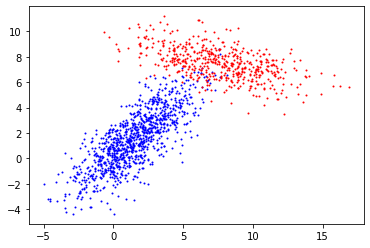

In [2]:
# Rotation Matrix 1
theta1 = -np.pi / 4
rotation_matrix1 = np.array([[np.cos(theta1), -np.sin(theta1)],
                            [np.sin(theta1), np.cos(theta1)]])

# Rotation Matrix 2
theta2 = np.pi / 3
rotation_matrix2 = np.array([[np.cos(theta2), -np.sin(theta2)],
                            [np.sin(theta2), np.cos(theta2)]])

# Scaling Matrix 1
scaling_matrix1 = np.array([[3, 0], [0, 1]])

# Scaling Matrix 2
scaling_matrix2 = np.array([[1, 2], [2, 1]])

# Shift 1
shift1 = 1.5

# Shift 2
shift2 = 7.5

gaussian1 = create_dataset(rotation_matrix1, scaling_matrix1, shift1, 1000)
y1 = np.zeros(1000)
gaussian2 = create_dataset(rotation_matrix2, scaling_matrix2, shift2, 500)
y2 = np.ones(500)

# plt.axis('equal')
plt.scatter(gaussian1[:, 0], gaussian1[:, 1], color='b', s=1)
plt.scatter(gaussian2[:, 0], gaussian2[:, 1], color='r', s=1)

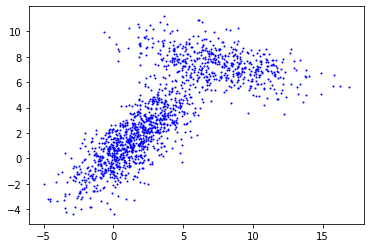

In [3]:
# Concatenate datasets
data = np.concatenate((gaussian1, gaussian2))
labels = np.concatenate((y1, y2))
plt.scatter(data[:, 0], data[:, 1], color='b', s=1)

In [4]:
N = data.shape[0]
mean = (1 / N) * np.sum(data, axis=0)
x_ = data - mean # Broadcast
var = (1 / N) * (np.dot(x_.T, x_))
print("Mean : {}".format(mean))
print("Mean with Numpy : {}".format(np.mean(data, axis=0)))

print("Variance : {}".format(var))
print("Variance with Numpy : {}".format(np.cov(data.T)))

Mean : [3.50364763 3.5080841 ]
Mean with Numpy : [3.50364763 3.5080841 ]
Variance : [[14.58866624 10.008909  ]
 [10.008909   11.85268082]]
Variance with Numpy : [[14.59839851 10.01558605]
 [10.01558605 11.86058788]]


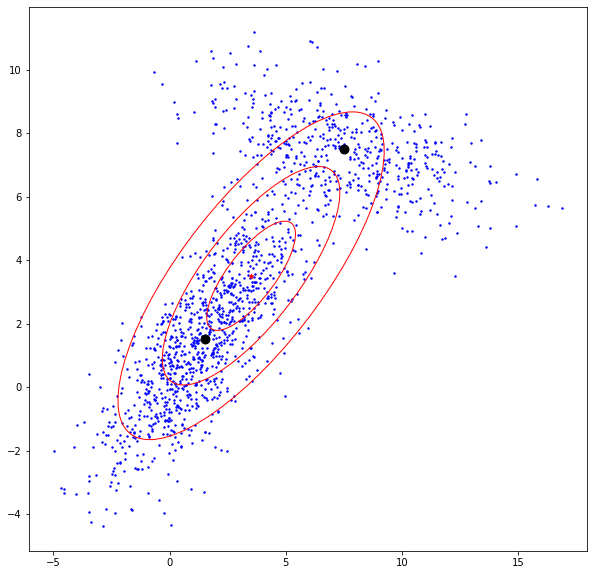

In [95]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [10, 10]

eig_values, eig_vectors = np.linalg.eig(var)

for i in range(1, 4):
    ellipse = Ellipse(xy=(mean[0], mean[1]), width=np.sqrt(eig_values[0]) * i,
                  height=np.sqrt(eig_values[1]) * i,
                  angle=np.rad2deg(np.arctan2(eig_vectors[1, 0], eig_vectors[0, 0])),
                 facecolor='none', edgecolor='red')
    ax.add_artist(ellipse)
# plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], color='blue', s=2)
plt.scatter(mean[0], mean[1], marker='*', color='red', s=20)
plt.scatter(1.5, 1.5, marker='o', color='black', s=80)
plt.scatter(7.5, 7.5, marker='o', color='black', s=80)

# K-Means Clustering - EM Light

In [6]:
# Build K-Means Clustering from scratch
import numpy.random as random
from math import inf
K = 2
idx1, idx2 = random.randint(0, len(data)), random.randint(0, len(data))
means = [data[idx1, :], data[idx2, :]]

assignment = [-1 for i in range(len(data))]

In [7]:
def define_cluster(assignment, gp, means):
    for i in range(0, len(gp)): # Assign each data sample to a cluster depending on its distance from the cluster center
        min_dist = inf
        for j in range(0, K):
            if np.linalg.norm(gp[i, :] - means[j]) < min_dist:
                min_dist = np.linalg.norm(gp[i, :] - means[j])
                assignment[i] = j
    return np.array(assignment)

def plot_clusters(assignment, gp, means):
    cluster1 = gp[assignment == 0]
    cluster2 = gp[assignment == 1]
    
    plt.scatter(cluster1[:, 0], cluster1[:, 1], color='red')
    plt.scatter(cluster2[:, 0], cluster2[:, 1], color='blue')
    
    plt.scatter(means[0, 0], means[0, 1], marker='^', color='black')
    plt.scatter(means[1, 0], means[1, 1], marker='^', color='black')
    
    plt.show()
    
    return cluster1, cluster2

Initialized Means : [0 8], [4 0]


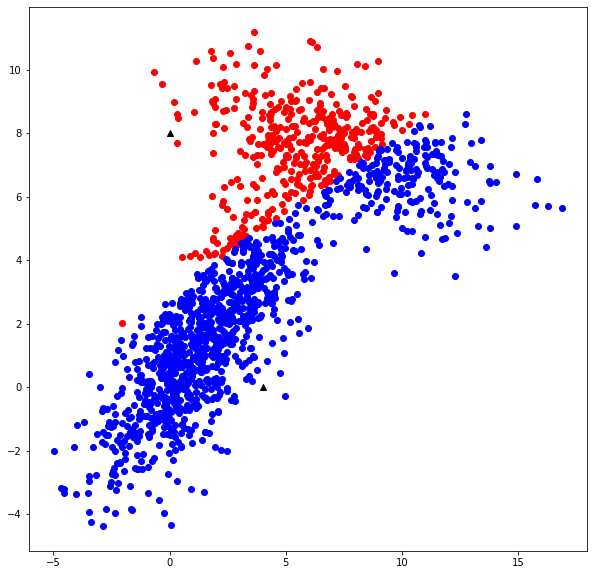

New Means : [5.27510619 7.59691242], [2.90895496 2.13543203]


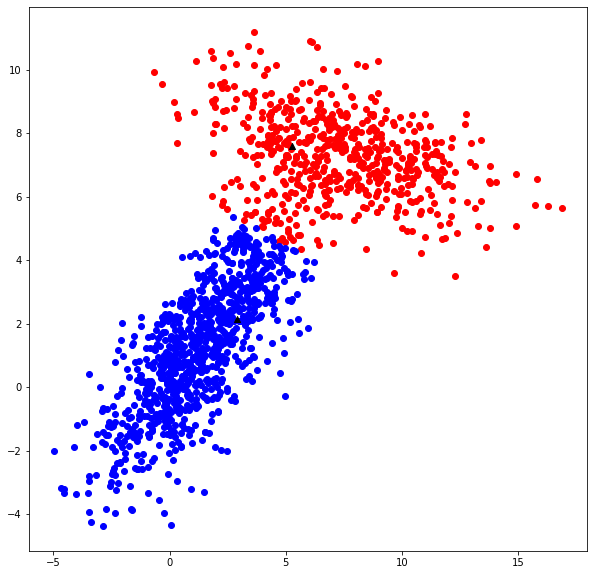

New Means : [7.2398514  7.26795031], [1.18114259 1.17086997]


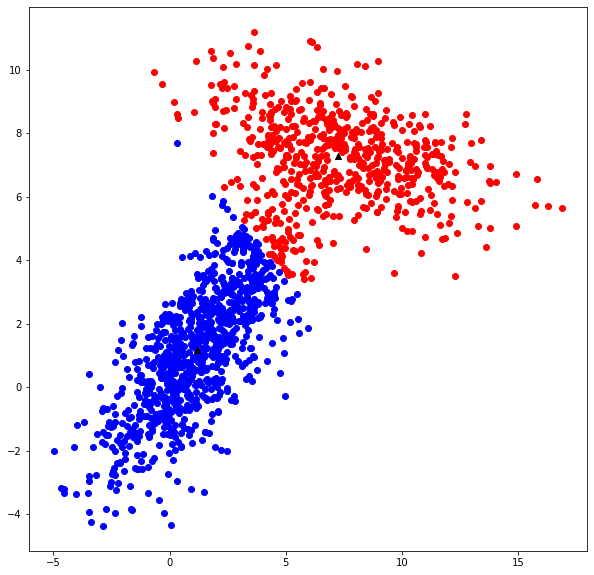

New Means : [7.17523456 7.1223462 ], [1.0627147  1.10526168]


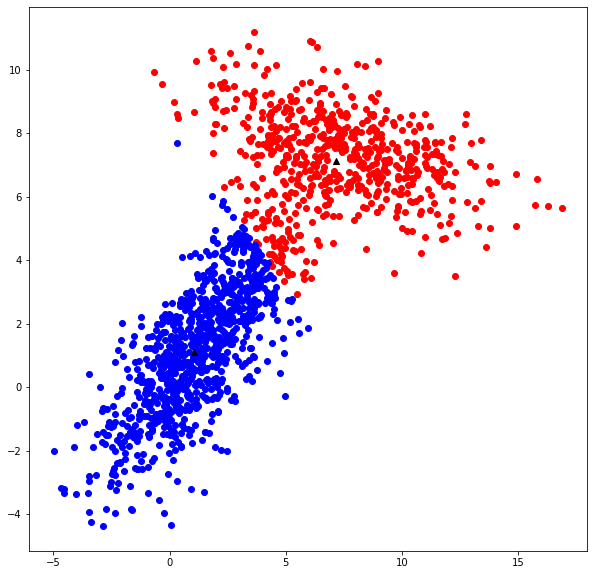

New Means : [7.14406135 7.08426511], [1.03598465 1.0839614 ]


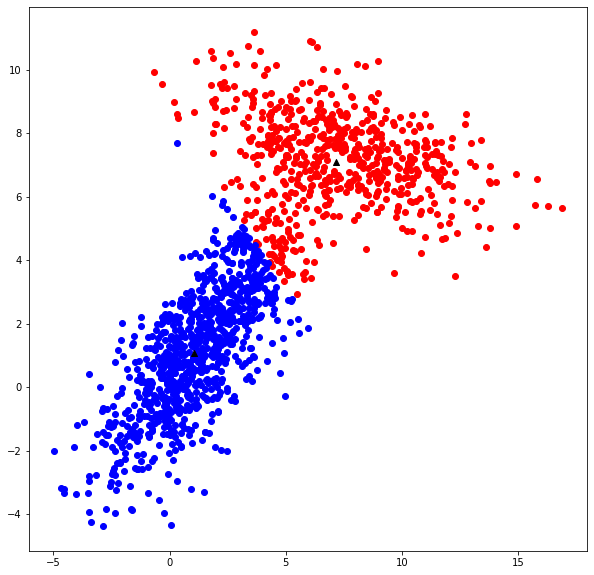

New Means : [7.14406135 7.08426511], [1.03598465 1.0839614 ]


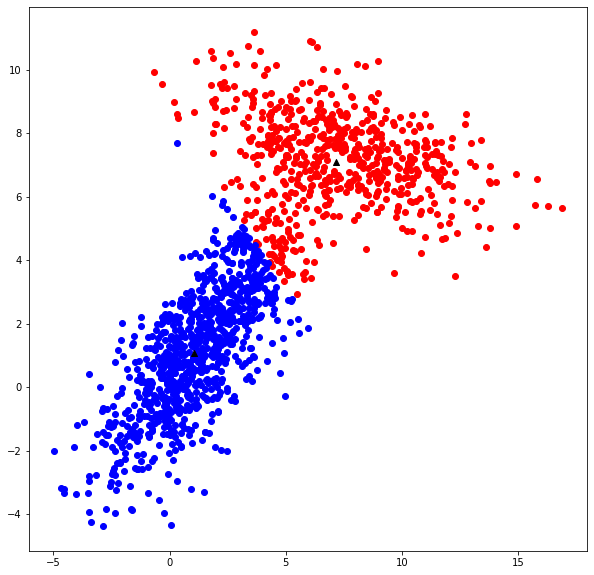

New Means : [7.14406135 7.08426511], [1.03598465 1.0839614 ]


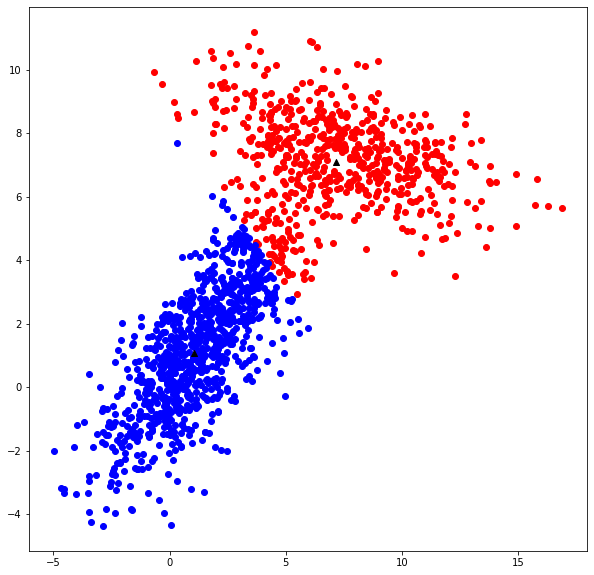

New Means : [7.14406135 7.08426511], [1.03598465 1.0839614 ]


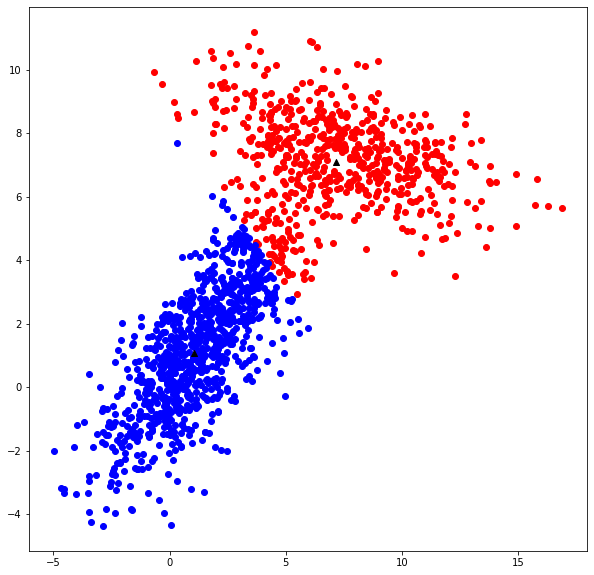

New Means : [7.14406135 7.08426511], [1.03598465 1.0839614 ]


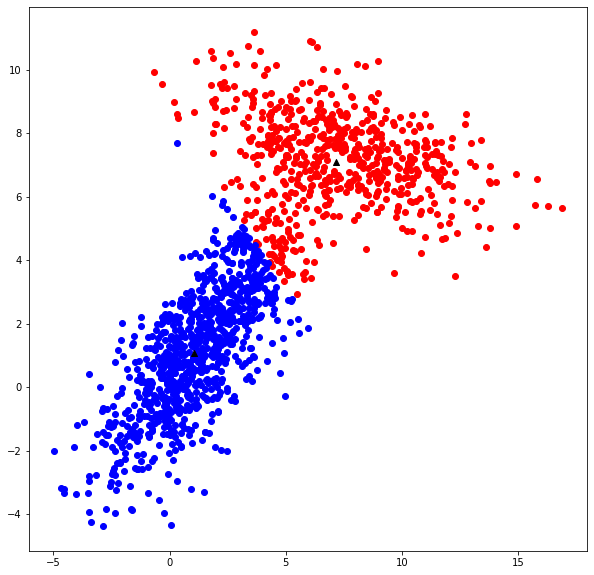

New Means : [7.14406135 7.08426511], [1.03598465 1.0839614 ]


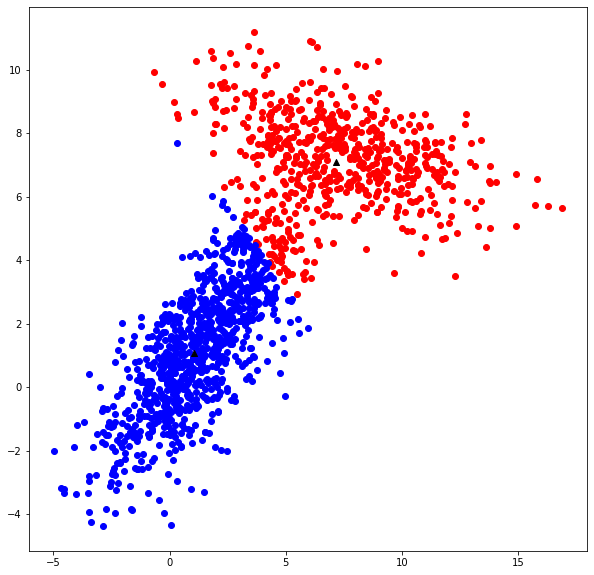

New Means : [7.14406135 7.08426511], [1.03598465 1.0839614 ]


In [8]:
means = np.array([[0, 8], [4, 0]])
print("Initialized Means : {}, {}".format(means[0, :], means[1, :]))
for i in range(0, 10):
    assignment = define_cluster(assignment, data, means)
    c1, c2 = plot_clusters(assignment, data, means)
    means = np.array([np.mean(c1, axis=0), np.mean(c2, axis=0)])
    print("New Means : {}, {}".format(np.mean(c1, axis=0), np.mean(c2, axis=0)))

# Expectation-Maximization

In [9]:
# Expectation Maximization from scratch
def initialize_parameters():
    means = np.array([[0.0, 4.0], [4.0, 4.0]])
    covs = np.array([np.asmatrix(np.identity(2)) for i in range(K)])
    weights = [1 / K for k in range(0, K)]
    
    return means, covs, weights
means, covs, weights = initialize_parameters()

In [94]:
from numpy import pi, exp

def multivariate_gaussian(x, mean, cov, d):
    x_diff = (x - mean)
    prod = 1 / ((np.linalg.det(cov) ** 0.5) * (2 * pi) ** (d / 2)) 
    return prod * exp(-0.5 * x_diff.T @ np.linalg.inv(cov) @ x_diff)

In [115]:
class EM:
    def __init__(self, K, x_n):
        self.K = K
        self.x_n = x_n
        self.covs = np.array([np.asmatrix(np.identity(2)) for i in range(self.K)])
        self.means = np.random.randn(K, 2)
        self.weights = [1 / K for k in range(0, K)]
        self.resp = np.zeros((x_n.shape[0], K))
        
    def E_step(self): 
        # Compute responsibilities for each sample with respect to each Gaussian Component
        for i in range(len(self.x_n)):
            for k in range(0, self.K):
                val = multivariate_gaussian(self.x_n[i, :], self.means[k, :], self.covs[k, :], 2)
                self.resp[i, k] = val * self.weights[k]

        self.resp = self.resp / np.sum(self.resp, axis=1)[:, None]

    def M_step(self):
        N_K = self.resp.sum(axis=0)[:, None]

        for k in range(0, self.K):
            # Update means using Responsibilities
            self.means[k, :] = (1 / N_K[k]) * np.sum(self.resp[:, k][:, np.newaxis] * self.x_n, axis=0)

            x_diff = self.x_n - self.means[k, :]
            
            # Update Covariance Matrix using responsibilities
            self.covs[k, :] = (1 / N_K[k]) * (x_diff.T * self.resp[:, k]).dot(x_diff)
            
            # Update Mixture coefficients (Weights)
            self.weights[k] = N_K[k] / self.x_n.shape[0]
            
    def expectation_maximization(self):
        for n in range(0, 20):
            # E Step
            self.E_step() 

            # M Step
            self.M_step()
            
        self.plot_EM_cluster()
            
            
    def plot_EM_cluster(self):
        fig, ax = plt.subplots()

        plt.scatter(self.x_n[:, 0], self.x_n[:, 1], c=self.resp[:, 0], cmap='GnBu')
        
        for k in range(self.K):            
            eig_values, eig_vectors = np.linalg.eig(self.covs[k])

            for i in range(5):
                ellipse = Ellipse(xy=(self.means[k, 0], self.means[k, 1]), width=np.sqrt(eig_values[0]) * i,
                              height=np.sqrt(eig_values[1]) * i,
                              angle=np.rad2deg(np.arctan2(eig_vectors[1, 0], eig_vectors[0, 0])),
                             facecolor='none', edgecolor='green')
                ax.add_artist(ellipse)
            plt.scatter(self.means[k, 0], self.means[k, 1], s=200, marker='^', color='red')

        plt.show()
    
    

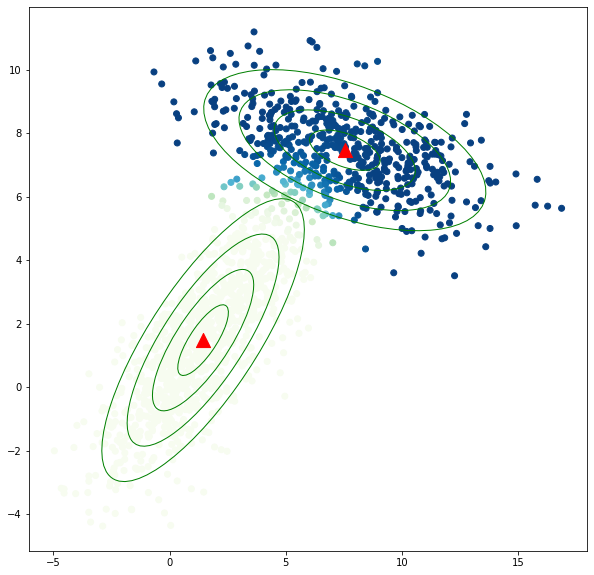

In [118]:
em = EM(2, data)
em.expectation_maximization()